In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from datetime import datetime

locations_df = pd.read_csv("csv-locations_12.9514242_77.6590212.csv")
# routes_df = pd.read_csv("csv-routes.csv")
routes_df = pd.DataFrame({
    "route_code": [
        "VJRQ+2M|RMJJ+F4",
        "WH5F+26|WJ8X+F5W",
        "XJPW+92|WJP4+FF",
        "2HVW+G8|XJXR+WG",
        "XHFC+WMF|WGGC+MG",
        "XPC7+72|XM33+J3",
        "WHCJ+26|XGCP+FV",
        "XMW9+G8|WMJR+V4",
        "XHJ7+MG|WJM6+VC",
        "WHR9+R6|XJGF+6J",
    ]
})
df = pd.read_csv("csv-bangalore_traffic.csv")
# Keep only those rows of df that correspond to those routes in routes_df
df = df[df['route_code'].isin(routes_df['route_code'])]

![routes.png](routes.png)

In [48]:
display(df.describe())
display(df.describe(exclude='number'))
display(df['route_code'].value_counts())

,duration,distance
count,290.000000,290.000000
mean,29.531034,10.310000
std,9.230651,0.590938
min,14.000000,9.400000
25%,22.000000,10.000000
50%,29.000000,10.200000
75%,37.750000,10.600000
max,58.000000,12.800000


,date,time,route_code
count,290,290,290
unique,2,28,10
top,2025-09-26,16:20,VJRQ+2M|RMJJ+F4
freq,190,20,29


route_code
VJRQ+2M|RMJJ+F4     29
WH5F+26|WJ8X+F5W    29
XJPW+92|WJP4+FF     29
2HVW+G8|XJXR+WG     29
XHFC+WMF|WGGC+MG    29
XPC7+72|XM33+J3     29
WHCJ+26|XGCP+FV     29
XMW9+G8|WMJR+V4     29
XHJ7+MG|WJM6+VC     29
WHR9+R6|XJGF+6J     29
Name: count, dtype: int64

In [49]:
# Process traffic data
df_traffic = df.copy()
df_traffic['year'] = pd.to_datetime(df_traffic['date']).dt.year
df_traffic['month'] = pd.to_datetime(df_traffic['date']).dt.month
df_traffic['date'] = pd.to_datetime(df_traffic['date']).dt.day
df_traffic['hour'] = pd.to_datetime(df_traffic['time'], format='%H:%M', errors='coerce').dt.hour
df_traffic['avg_speed'] = round(df_traffic['distance'] / (df_traffic['duration'] / 60), 2)
df_traffic['origin'] = df_traffic['route_code'].str.split('|').str[0]
df_traffic['destination'] = df_traffic['route_code'].str.split('|').str[1]
df_traffic['origin'] = df_traffic['origin'].map(locations_df.set_index('plus_code')['location'])
df_traffic['destination'] = df_traffic['destination'].map(locations_df.set_index('plus_code')['location'])
df_traffic = df_traffic[['year', 'month', 'date', 'hour', 'origin', 'destination', 'duration', 'distance', 'avg_speed']]
df_traffic = df_traffic.sort_values(['year', 'month', 'date', 'hour', 'duration'], ascending=[True, True, True, True, True]).reset_index(drop=True)
display(df_traffic.tail(15))

,year,month,date,hour,origin,destination,duration,distance,avg_speed
275,2025,9,26,18,Lulu Mall Bengaluru,Nexus Mall Koramangala,39,11.0,16.92
276,2025,9,26,18,"Big Bull Temple, Basavanagudi","Shri Someshwara Swamy Temple, Halasuru",43,10.7,14.93
277,2025,9,26,18,Swami Vivekananda Road Metro Station,"Christ University, Hosur Main Road",44,10.4,14.18
278,2025,9,26,18,"RV Road Metro Station, Jayanagar 5th Block","Vijayanagar Metro Station, Chord Road",47,10.1,12.89
279,2025,9,26,18,"Kempegowda Bus Station, Majestic","Sparsh Hospital, RR Nagar",58,12.7,13.14
280,2025,9,26,19,Benniganahalli Metro Station,"Embassy TechVillage, Devarabisanahalli",22,10.1,27.55
281,2025,9,26,19,Jaya Prakash Nagar Metro Station,"Hemavathi Park, HSR Layout",27,10.7,23.78
282,2025,9,26,19,Kudlu Gate Metro Station,Biocon Campus,30,10.9,21.80
283,2025,9,26,19,The Rameshwaram Cafe @ Brookfield,"Gawky Goose, Wind Tunnel Rd",33,9.4,17.09
284,2025,9,26,19,"Bethel AG Church, Hebbal",SMVT Railway Station,39,9.9,15.23


In [50]:
# Build timestamps from the loaded traffic_df
df['ts'] = pd.to_datetime(df['date'] + ' ' + df['time'], errors='coerce')
df = df.dropna(subset=['ts']).sort_values('ts')

# Last 24h window relative to the dataset’s latest timestamp
end = df['ts'].max()
start = end - pd.Timedelta(hours=24)
df_24 = df[(df['ts'] >= start) & (df['ts'] <= end)].copy()

# Human-readable labels from locations CSV
loc_map = locations_df.set_index("plus_code")["location"].to_dict()

def label_for_route(route_code: str) -> str:
    try:
        o, d = route_code.split("|", 1)
    except ValueError:
        return route_code
    o_name = loc_map.get(o, o)
    d_name = loc_map.get(d, d)
    return f"{o_name} \u2192 {d_name}"  # → arrow

# Build a common timeline (all observed timestamps in the window)
timeline = pd.Index(sorted(df_24['ts'].unique()))

# Helper: neighbor-mean fill for a single route frame indexed by 'ts'
# - Fill duration by neighbor mean
# - Carry distance via ffill/bfill
def fill_route(frame_idx_ts: pd.DataFrame, route_code: str) -> pd.DataFrame:
    g = frame_idx_ts.reindex(timeline)

    # Keep route_code + distance
    g['route_code'] = g['route_code'].ffill().bfill()
    if g['route_code'].isna().all():
        g['route_code'] = route_code

    # Distance: carry forward/back; assume stable per route per timestamp
    g['distance'] = pd.to_numeric(g['distance'], errors='coerce')
    g['distance_filled'] = g['distance'].ffill().bfill()

    # Duration: neighbor-mean fill
    durations = pd.to_numeric(g['duration'], errors='coerce')
    prev_vals = durations.ffill()
    next_vals = durations.bfill()
    filled = durations.copy()

    mask_missing = durations.isna()
    mask_both = mask_missing & prev_vals.notna() & next_vals.notna()
    filled.loc[mask_both] = (prev_vals.loc[mask_both] + next_vals.loc[mask_both]) / 2.0

    mask_prev_only = mask_missing & prev_vals.notna() & next_vals.isna()
    mask_next_only = mask_missing & next_vals.notna() & prev_vals.isna()
    filled.loc[mask_prev_only] = prev_vals.loc[mask_prev_only]
    filled.loc[mask_next_only] = next_vals.loc[mask_next_only]

    g['duration_filled'] = filled

    # Average speed (km/h) = 60 * distance_km / duration_min
    dur_safe = g['duration_filled'].replace(0, pd.NA)
    g['speed_kmph'] = 60.0 * g['distance_filled'] / dur_safe
    return g.reset_index(names='ts')

# Process each route explicitly (no groupby.apply to avoid warnings)
frames = []
for route in sorted(df_24['route_code'].unique()):
    r = df_24.loc[df_24['route_code'] == route, ['ts', 'route_code', 'duration', 'distance']].set_index('ts')
    frames.append(fill_route(r, route))

df_filled = pd.concat(frames, ignore_index=True).sort_values(['ts', 'route_code'])
df_filled['label'] = df_filled['route_code'].apply(label_for_route)

# Smooth/curvy lines on speed
def smooth_series(ts: pd.Series, ys: pd.Series) -> pd.Series:
    mask_valid = ys.notna()
    ts_valid = ts[mask_valid]
    ys_valid = ys[mask_valid]

    if len(ys_valid) < 3:
        return ys

    try:
        from scipy.interpolate import PchipInterpolator
        x = ts_valid.map(pd.Timestamp.toordinal).to_numpy(dtype=float)
        y = ys_valid.to_numpy(dtype=float)
        x_all = ts.map(pd.Timestamp.toordinal).to_numpy(dtype=float)
        interp = PchipInterpolator(x, y)
        return pd.Series(interp(x_all), index=ts)
    except Exception:
        # Fallback: centered rolling mean
        win = 3 if len(ys_valid) < 10 else 5
        return ys.rolling(window=win, center=True, min_periods=1).mean()

# Create a 1D Series aligned to df_filled.index without groupby.apply
speed_smooth = pd.Series(index=df_filled.index, dtype=float)
for label, idx in df_filled.groupby('label').groups.items():
    g = df_filled.loc[idx]
    y_smooth = smooth_series(g['ts'], g['speed_kmph'])
    speed_smooth.loc[idx] = y_smooth.values

df_filled['speed_smooth'] = speed_smooth

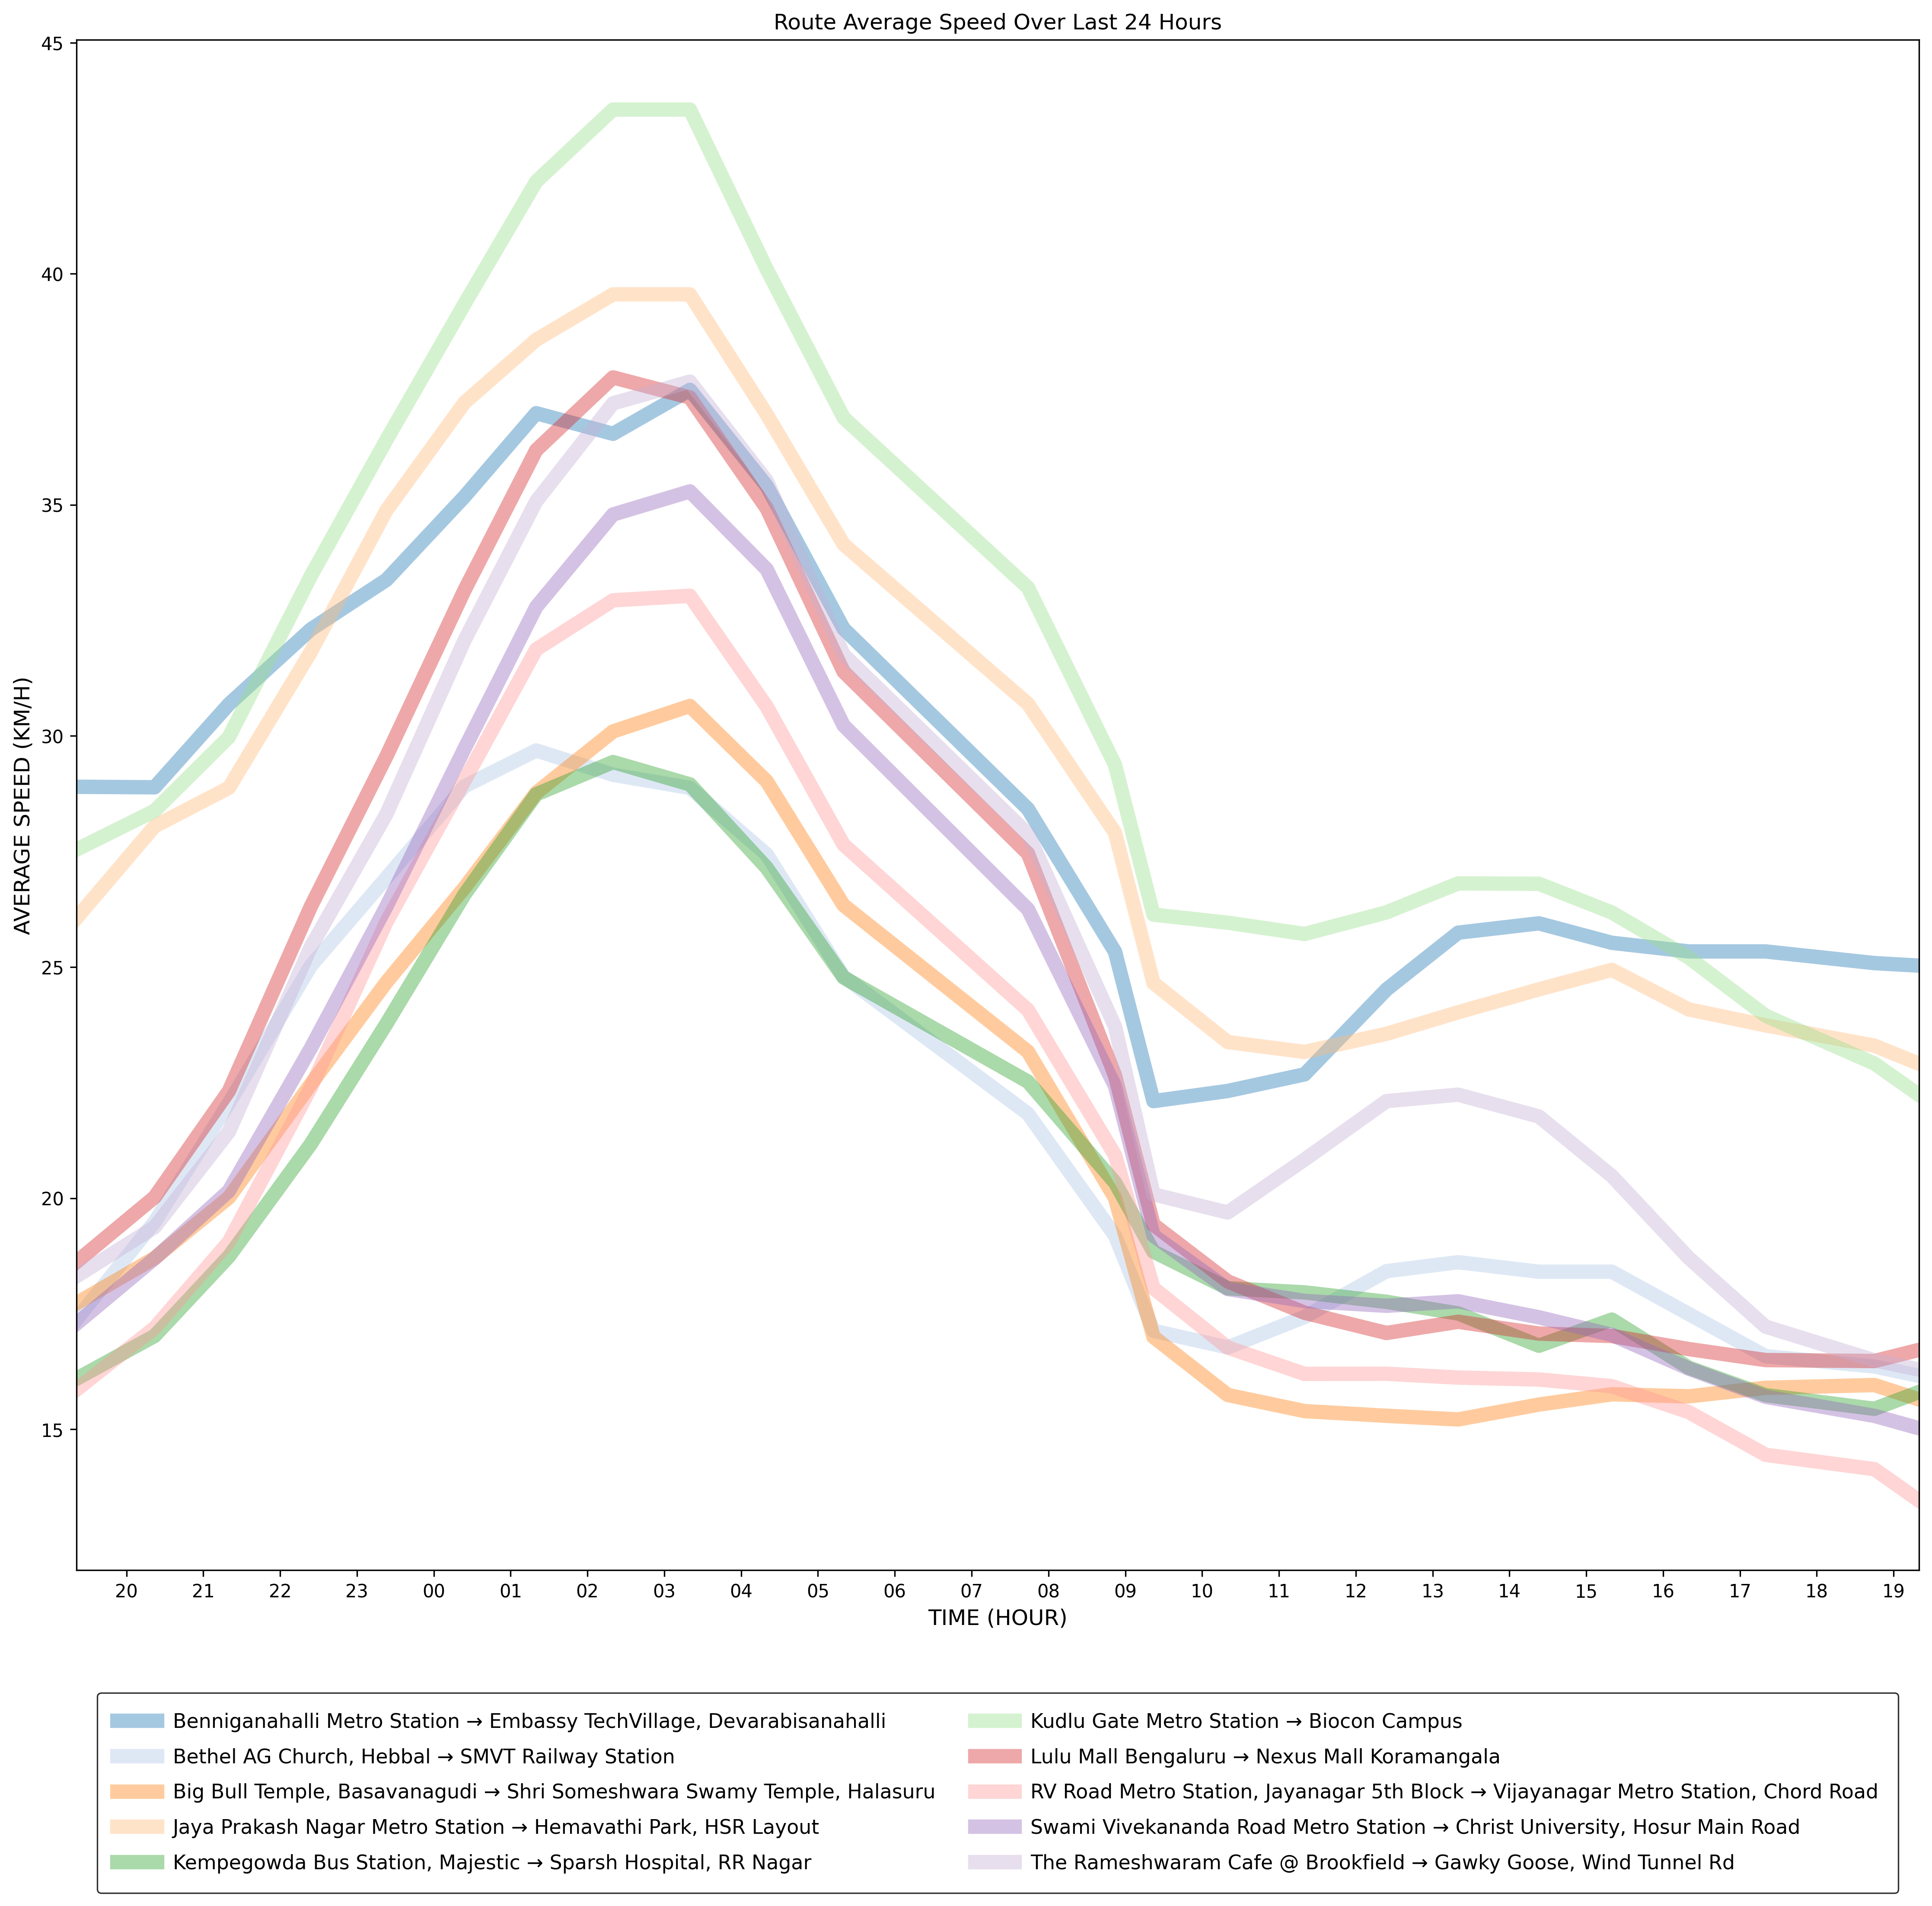

In [51]:
# Plot: average speed, legend outside (or move below), HH-only x-axis
hue_order = sorted(df_filled['label'].unique())
palette = sns.color_palette("tab20", n_colors=len(hue_order))
color_map = dict(zip(hue_order, palette))           # label -> RGB color

fig, ax = plt.subplots(figsize=(16, 16), dpi=300)
sns.lineplot(
    data=df_filled,
    x='ts', y='speed_smooth',
    hue='label',
    hue_order=hue_order,
    palette=palette,
    ax=ax,
    linewidth=8, alpha=0.4
)
ax.margins(x=0)  # remove automatic horizontal padding
ax.set_xlim(df_filled['ts'].min(), df_filled['ts'].max())

# X-axis as hours only (HH)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H'))
ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))
ax.set_xlabel('Time (Hour)'.upper(), fontsize=12)
ax.set_ylabel('Average Speed (km/h)'.upper(), fontsize=12)
ax.set_title('Route Average Speed Over Last 24 Hours')

# Legend outside on the bottom:
handles, labels = ax.get_legend_handles_labels()
leg = ax.legend(
    handles, labels,
    loc='upper center',
    bbox_to_anchor=(0.5, -0.08),  # keep your preferred anchor
    ncol=2,
    frameon=True,
    borderaxespad=0.0,
    fontsize=11,
    borderpad=1.0,     # inner frame padding
    labelspacing=0.8   # spacing between legend entries
)
leg.get_frame().set_linewidth(0.8)
leg.get_frame().set_edgecolor('#000000')
plt.tight_layout()
plt.subplots_adjust(bottom=0.24)
plt.show()

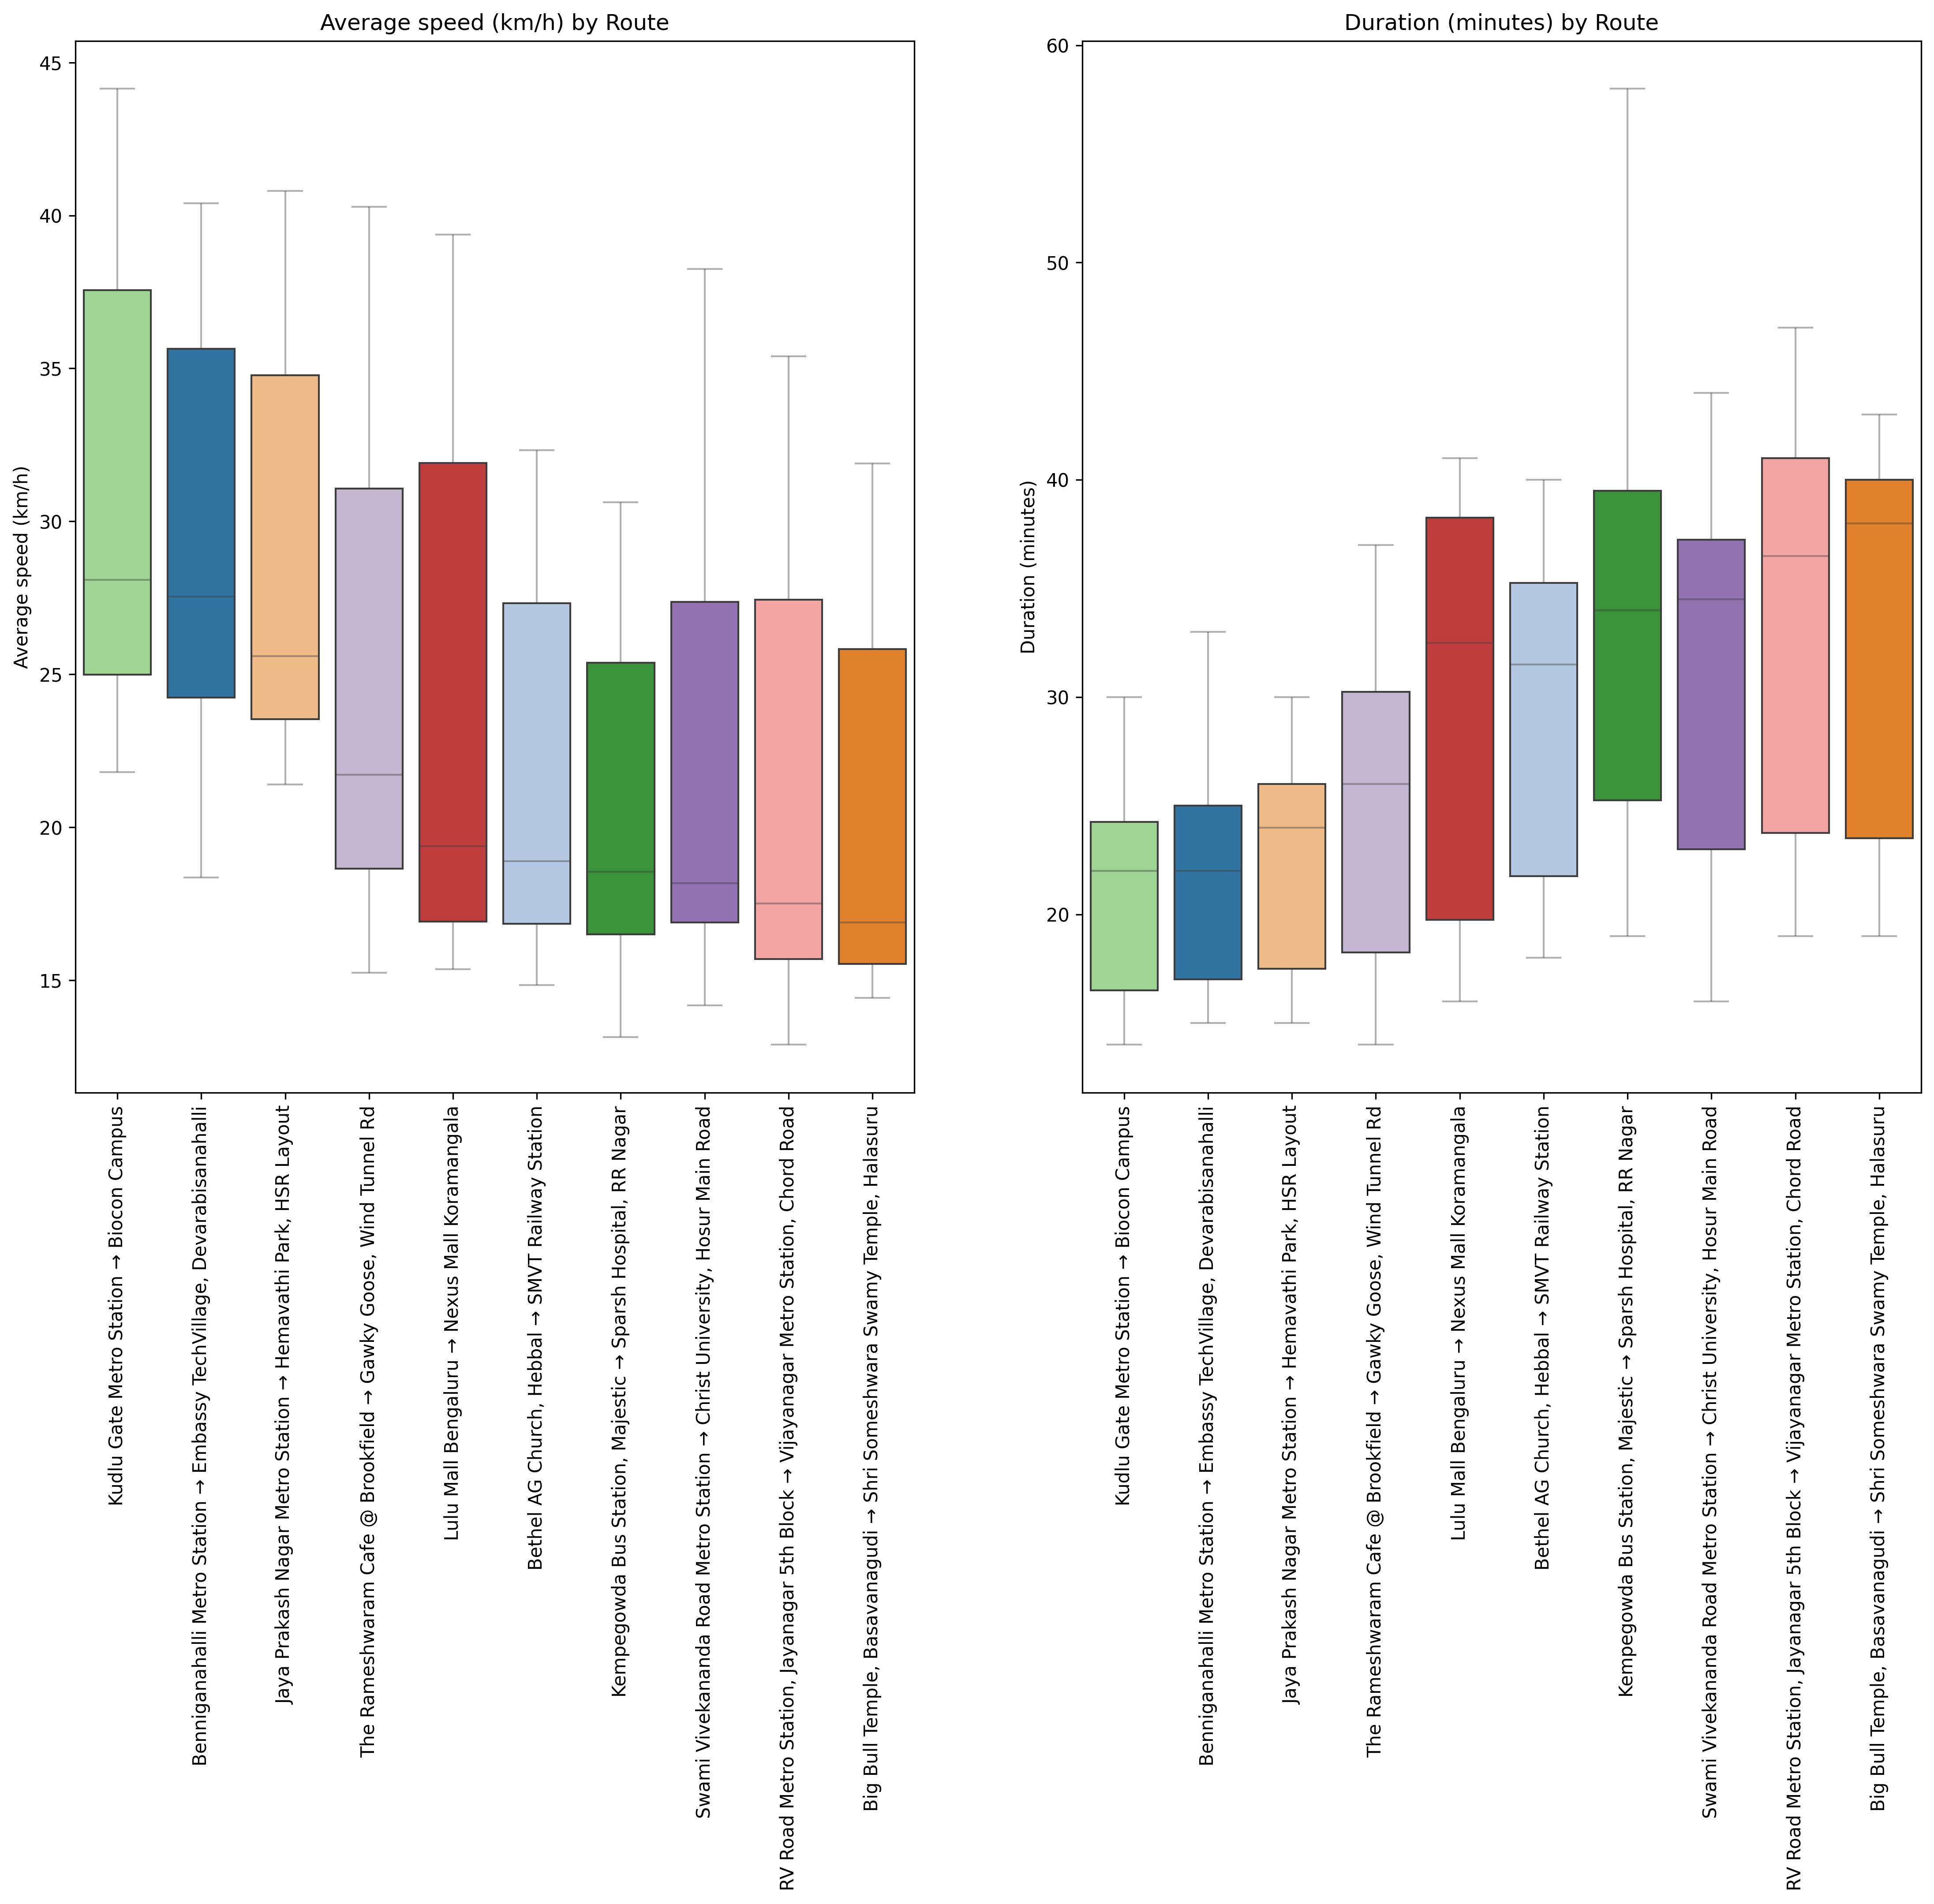

In [52]:
# Boxplots for duration, distance, and average speed per route
df_box = df_filled.copy()
df_box['ts'] = pd.to_datetime(df_box['ts'], errors='coerce')
df_box = df_box.dropna(subset=['ts'])

# Human-readable labels
loc_map = (locations_df.set_index("plus_code")["location"].to_dict())

def label_for_route(code: str) -> str:
    try:
        origin_code, dest_code = code.split("|", 1)
    except ValueError:
        return code
    origin = loc_map.get(origin_code, origin_code)
    dest = loc_map.get(dest_code, dest_code)
    return f"{origin} \u2192 {dest}"

df_box['label'] = df_box['route_code'].map(label_for_route)

# Average speed (km/h)
df_box['avg_speed'] = 60.0 * df_box['distance'] / df_box['duration'].replace(0, pd.NA)

metrics = [
    ('avg_speed', 'Average speed (km/h)'),
    ('duration', 'Duration (minutes)')
]

# Sort routes by median duration (ascending)
route_order = (
    df_box.groupby('label')['avg_speed']
          .median()
          .sort_values(ascending=False)
          .index.tolist()
)

fig, axes = plt.subplots(1, len(metrics), figsize=(18, 15), sharex=False, dpi=300)

for ax, (metric, ylabel) in zip(axes, metrics):
    sns.boxplot(
        data=df_box,
        x='label',
        y=metric,
        hue='label',                # tie palette to hue to silence warning
        order=route_order,
        hue_order=route_order,
        palette=color_map,
        dodge=False, 
        legend=False,
        ax=ax
    )
    # Make box faces semi-transparent
    for patch in ax.artists:          # each box in matplotlib ≥3.4
        fc = patch.get_facecolor()
        patch.set_facecolor((*fc[:3], 0.4))  # preserve RGB, set alpha=0.4

    for line in ax.lines:             # whiskers, medians, caps
        line.set_alpha(0.4)

    ax.set_xlabel('')
    ax.set_ylabel(ylabel)
    ax.set_title(f'{ylabel} by Route')
    ax.tick_params(axis='x', rotation=90, labelbottom=True, bottom=True)

plt.subplots_adjust(bottom=0.35)
plt.show()